In [1]:
import pandas as pd
import geopandas as gp
from shapely import geometry
import matplotlib.pyplot as plt
from dbfread import DBF
from osgeo import ogr,osr
from math import ceil,log
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
from shapely.geometry import Point,MultiPoint
from shapely.ops import voronoi_diagram
# Import arcpy module
# import arcpy
def  main_polat(inpath,outpath,width,height):

    def spatial_transform(widths,heights):

        area = widths*heights ## 面积
        l = np.sqrt((2*area)/(3*np.sqrt(3))) ##蜂窝边长
        cellWidth = 3*l ## 渔网宽度
        cellHeight = (np.sqrt(3))*l ## 渔网高度
        deltaX = 1.5 * l ## 横向偏移
        deltaY = (np.sqrt(3)/2)*l ## 纵向偏移

        return l,cellWidth,cellHeight,deltaX,deltaY 
    l,cellWidth,cellHeight,deltaX,deltaY = spatial_transform(width,height)
    
    def Fishgrid(outfile,xmin,xmax,ymin,ymax,gridwidth,gridheight):
        #参数转换到浮点型
        
        xmin = float(xmin)
        xmax = float(xmax)
        ymin = float(ymin)
        ymax = float(ymax)
        gridwidth = float(gridwidth)
        gridheight = float(gridheight)

        #计算行数和列数

        rows = ceil((ymax-ymin)/gridheight)
        cols = ceil((xmax-xmin)/gridwidth)
        #初始化起始格网四角范围
        ringXleftOrigin = xmin
        ringXrightOrigin = xmin+gridwidth
        ringYtopOrigin = ymax
        ringYbottomOrigin = ymax-gridheight

        #创建输出文件
        outdriver = ogr.GetDriverByName('ESRI Shapefile')
        if os.path.exists(outfile):
            outdriver.DeleteDataSource(outfile)
        outds = outdriver.CreateDataSource(outfile)
        outlayer = outds.CreateLayer(outfile,geom_type = ogr.wkbPolygon)
        #不添加属性信息，获取图层属性
        outfielddefn  = outlayer.GetLayerDefn()
        #遍历列，每一列写入格网
        col = 0
        while col<cols:
            #初始化，每一列写入完成都把上下范围初始化
            ringYtop = ringYtopOrigin
            ringYbottom = ringYbottomOrigin
            #遍历行，对这一列每一行格子创建和写入
            row = 0
            while row<rows:
                #创建左上角第一个格子
                ring = ogr.Geometry(ogr.wkbLinearRing)
                ring.AddPoint(ringXleftOrigin,ringYtop)
                ring.AddPoint(ringXrightOrigin,ringYtop)
                ring.AddPoint(ringXrightOrigin,ringYbottom)
                ring.AddPoint(ringXleftOrigin,ringYbottom)
                ring.CloseRings()
                #写入几何多边形
                poly = ogr.Geometry(ogr.wkbPolygon)
                poly.AddGeometry(ring)
                #创建要素，写入多边形
                outfeat = ogr.Feature(outfielddefn)
                outfeat.SetGeometry(poly)
                #写入图层
                outlayer.CreateFeature(outfeat)
                outfeat = None
                #下一多边形，更新上下范围
                row+=1
                ringYtop = ringYtop - gridheight
                ringYbottom = ringYbottom-gridheight
            #一列写入完成后，下一列，更新左右范围
            col+=1
            ringXleftOrigin = ringXleftOrigin+gridwidth
            ringXrightOrigin = ringXrightOrigin+gridwidth
        #写入后清除缓存
        outds = None
    xian = gpd.read_file(inpath)#读取文件
    xian.plot(fc='w',ec='grey')
    
    Fishgrid('xian_pcs_gw',
         xmin=xian.bounds.minx-cellWidth,
         ymin=xian.bounds.miny-cellHeight,
         xmax=xian.bounds.maxx+cellWidth,
         ymax=xian.bounds.maxy+cellHeight,
         gridwidth=cellWidth,
         gridheight=cellHeight)
    xian_pcs_gw=gpd.read_file('xian_pcs_gw')
    xian_pcs_gw.set_crs(xian.crs,inplace=True)
    xian_pcs_gw.crs
    pointvalue = xian_pcs_gw.geometry.centroid
    ax=xian_pcs_gw.plot(fc='w',ec='grey')
    xian.plot(fc='w',ec='grey',ax=ax)
    pointvalue.plot(fc='w',ec='grey',ax=ax,markersize=1)
    point = pd.DataFrame()
    point['x'] = pointvalue.geometry.x
    point['y'] = pointvalue.geometry.y
    point_transform = pd.DataFrame()
    point_transform['x'] = point['x']+deltaX
    point_transform['y'] = point['y']+deltaY 
    point = pd.concat([point,point_transform],axis=0)
    point.index = range(point.shape[0])
    point_new = gpd.GeoDataFrame(data=point,
                                geometry=gpd.points_from_xy(point['x'],point['y']),
                                crs=xian.crs)
    multipoint=MultiPoint(point_new.geometry)
    ploygon=gpd.GeoSeries(voronoi_diagram(multipoint).geoms)
    ax=xian.plot(fc='w',ec='grey')
    ploygon.plot(fc='w',ec='grey',ax=ax)
    ploygon.set_crs(xian.crs,inplace=True)
    index=list()
    for i,p in zip(range(ploygon.shape[0]),ploygon):
        if xian.intersects(p).bool()==True:
            index.append(i)
    ploygon1=ploygon[index]
    ploygon1.index=range(ploygon1.shape[0])
    ax=ploygon1.plot(fc='w',ec='grey',figsize=(10,8))
    xian.plot(fc='green',ax=ax,alpha=0.3)
    ploygon_need = gpd.GeoDataFrame(data={'id':range(1,ploygon1.shape[0]+1)},
                                    geometry=ploygon1)
    ploygon_need.to_file(outpath)#输出文件
    
def variables(inpath1,inpath2,dbfoutpath):
    gdf_left = gpd.read_file(inpath1)#输入蜂窝六边形文件
    gdf_left_area = gdf_left['geometry'].area 
    gdf_right = gpd.read_file(inpath2)#输入绿洲
    boundary_cores = gpd.overlay(gdf_left, gdf_right, how='intersection')
    gdf_right_area =boundary_cores['geometry'].area 
    Percentage=(gdf_right_area/gdf_left_area )*100#面积占比
    papers = []
    for i in range(len(Percentage)):#保存面积占比
        paper={"FID":i+1,"PERCENTAGE":Percentage[i]}
        papers.append(paper)
    pd.DataFrame(papers).to_csv(dbfoutpath,encoding='utf-8')  #完整导出

#验证点位
def save_points(sixdata,lvdata,csvdata,exceeddata):
    loadData = gp.read_file(sixdata)#读取蜂窝六边形的
    xian = gpd.read_file(lvdata)#读取绿洲数据
    s = pd.DataFrame(loadData)
    b=pd.read_csv(csvdata)#读取占比数据
    #划分随机点
    def generate_random_points(polygon, num_points):
        # 存储点
        random_points = []
        while len(random_points) < num_points:
            # 生成随机坐标
            min_x, min_y, max_x, max_y = polygon.bounds  # 注意根据你的多边形数据格式进行更改
            random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
    #         print(random_points)
            # 检查点是否在多边形内
            if polygon.contains(random_point):  # 注意根据你的多边形数据格式进行更改
                random_points.append(random_point)

        # 将得到的点作为结果返回
        return random_points
    pointss = []
    for i in range(len(b['FID'])):
        if b['FID'][i] == s['id'][i] :
            if b['PERCENTAGE'][i]<20:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,5)
                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>20 and b['PERCENTAGE'][i]<40:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,10)
                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>40 and b['PERCENTAGE'][i]<60:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,15)

                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>60 and b['PERCENTAGE'][i]<80:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,20)

                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>80:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,25)
                for i in points:
                    pointss.append(i)
    """生成图"""                
    gdf_points = gpd.GeoDataFrame(geometry=pointss)
    ax=loadData.plot(fc='w',ec='grey',figsize=(10,8))
    # 多点
    xian.plot(fc='green',ax=ax,alpha=0.3)
    ax1 = gdf_points.plot(ax=ax, color='blue', markersize=0.3)
    # 显示地图
    plt.show()                
    '''验证生成的随机点是否在绿洲范围内'''
    papers = []
    polygon = xian
    for i in pointss:
        if polygon.contains(i)[0] == False:
            paper={'点位':i}
            papers.append(paper)
    points=pd.DataFrame(papers)
    points.to_csv(exceeddata)#超出点的位置
    

输入绿洲数据路径D:\gisdata\new\HFOCD\HFOCD.shp
输出蜂窝六边形数据保存地址D:\gisdata\new\HFOCD\d\d.shp
宽度50000
高度50000
输出csv文件位置D:\gisdata\new\HFOCD\bai.csv
输出不在绿洲的点的位置D:\gisdata\new\HFOCD\e.csv


TypeError: cannot convert the series to <class 'float'>

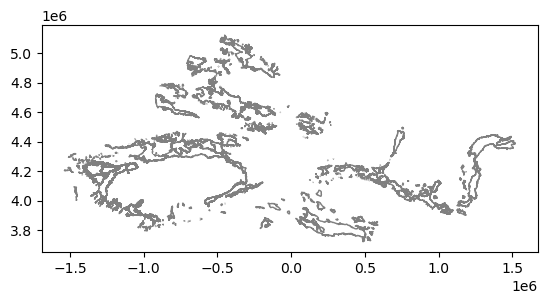

In [2]:

if __name__ == '__main__' :
    #生成蜂窝六边形输入文件
    lvpath =input('输入绿洲数据路径') #输入绿洲数据路径
    sixpath = input('输出蜂窝六边形数据保存地址')#输出蜂窝六边形数据
    w = float(input('宽度'))
    h =float(input('高度'))
    #交集制表输入文件
    dbfoutpath = input('输出csv文件位置')#输出csv文件
    #输出交集表
    exceeddata =input('输出不在绿洲的点的位置')#输出不在绿洲位置
    main_polat(lvpath,sixpath,w,h)
    variables(sixpath,lvpath,dbfoutpath)
    save_points(sixpath,lvpath,dbfoutpath,exceeddata)


In [50]:
def save_points(sixdata,lvdata,csvdata,exceeddata):
    loadData = gp.read_file(sixdata)#读取蜂窝六边形的
    xian = gpd.read_file(lvdata)#读取绿洲数据
    s = pd.DataFrame(loadData)
    b=pd.read_csv(csvdata)#读取占比数据
    print(b)
    #划分随机点
    def generate_random_points(polygon, num_points):
        # 存储点
        random_points = []
        while len(random_points) < num_points:
            # 生成随机坐标
            min_x, min_y, max_x, max_y = polygon.bounds  # 注意根据你的多边形数据格式进行更改
            random_point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
    #         print(random_points)
            # 检查点是否在多边形内
            if polygon.contains(random_point):  # 注意根据你的多边形数据格式进行更改
                random_points.append(random_point)

        # 将得到的点作为结果返回
        return random_points
    pointss = []
    for i in range(len(b['FID'])):

        if b['FID'][i]+1 == s['id'][i] :
            if b['PERCENTAGE'][i]<20:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,5)
                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>20 and b['PERCENTAGE'][i]<40:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,10)
                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>40 and b['PERCENTAGE'][i]<60:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,15)

                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>60and b['PERCENTAGE'][i]<80:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,20)

                for i in points:
                    pointss.append(i)
            elif b['PERCENTAGE'][i]>80:
                polygon = loadData['geometry'][i]
                points = generate_random_points(polygon,25)
                for i in points:
                    pointss.append(i)
    """生成图"""                
    gdf_points = gpd.GeoDataFrame(geometry=pointss)
    ax=loadData.plot(fc='w',ec='grey',figsize=(10,8))
    # 多点
    xian.plot(fc='green',ax=ax,alpha=0.3)
    ax1 = gdf_points.plot(ax=ax, color='red', markersize=0.5)
    # 显示地图
    plt.show()                
    '''验证生成的随机点是否在绿洲范围内'''
    papers = []
    polygon = xian
    for i in pointss:
        if polygon.contains(i)[0] == False:
            paper={'点位':i}
            papers.append(paper)
    points=pd.DataFrame(papers)
    points.to_csv(exceeddata)#超出点的位置

In [54]:
loadData = r"D:\gisdata\阿克苏\d\d.shp"#读取蜂窝六边形的
xian = r"D:\gisdata\阿克苏"#读取绿洲数据

b=r'D:\\gisdata\\阿克苏\\c\\xinbiao.csv'#读取占比数据
exceeddata = 'D:\gisdata\昌马绿洲\d\dian.csv'

****************************************


     Unnamed: 0  FID  PERCENTAGE
0             0    0    4.538014
1             1    1   13.799739
2             2    2   10.780388
3             3    3    2.661892
4             4    4   75.442747
..          ...  ...         ...
292         292  292   43.763778
293         293  293   76.451272
294         294  294   28.458455
295         295  295    7.774063
296         296  296   10.159500

[297 rows x 3 columns]


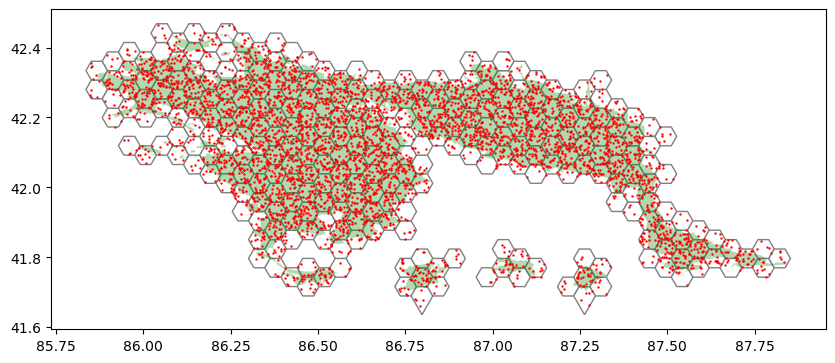

In [55]:
save_points(loadData,xian,b,exceeddata)

In [32]:
b

'D:\\\\gisdata\\\\阿克苏\\\\d\\\\xinbiao.csv'